# SNN with CODEnn Dataset


In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
import random
import numpy as np
import tables
from tqdm import tqdm
from tensorflow.keras.losses import cosine_similarity

In [2]:
# All load_hdf5(), pad(), load_pickle() functions obtained from Deep Code search repository
def load_hdf5(vecfile, start_offset, chunk_size):
    """reads training sentences(list of int array) from a hdf5 file"""  
    table = tables.open_file(vecfile)
    data = table.get_node('/phrases')[:].astype(np.int)
    index = table.get_node('/indices')[:]
    data_len = index.shape[0]
    if chunk_size==-1:#if chunk_size is set to -1, then, load all data
        chunk_size=data_len
    start_offset = start_offset%data_len    
    sents = []
    for offset in tqdm(range(start_offset, start_offset+chunk_size)):
        offset = offset%data_len
        len, pos = index[offset]['length'], index[offset]['pos']
        sents.append(data[pos:pos + len])
    table.close()
    return sents

def pad(data, len=None):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    return pad_sequences(data, maxlen=len, padding='post', truncating='post', value=0)

import pickle

def load_pickle(filename):
    return pickle.load(open(filename, 'rb'))   

In [3]:
data_path = "../data/codenn/dummy/"

file_format = "h5"

# 18223872 (len) #1000000
train_tokens = load_hdf5( data_path+"train.tokens."+file_format, 0, 1000000)
train_desc = load_hdf5( data_path+"train.desc."+file_format, 0, 1000000)
# Negative sampling
train_bad_desc = load_hdf5( data_path+"train.desc."+file_format, 0, 1000000)
random.shuffle(train_bad_desc)
vocabulary_tokens = load_pickle(data_path+"vocab.tokens.pkl")
vocabulary_desc = load_pickle(data_path+"vocab.desc.pkl")

100%|████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:05<00:00, 188106.17it/s]


In [4]:
code_vector = train_tokens
desc_vector = train_desc
bad_desc_vector = train_bad_desc

longer_code = max(len(t) for t in code_vector)
longer_desc = max(len(t) for t in desc_vector)

longer_sentence = max(longer_code, longer_desc)

code_vector = pad(code_vector, longer_code)
desc_vector = pad(desc_vector, longer_desc)
bad_desc_vector = pad(bad_desc_vector, longer_desc)

number_desc_tokens = len(vocabulary_desc)
number_code_tokens = len(vocabulary_tokens)
print(longer_sentence, number_code_tokens, number_desc_tokens)

80 10001 10001


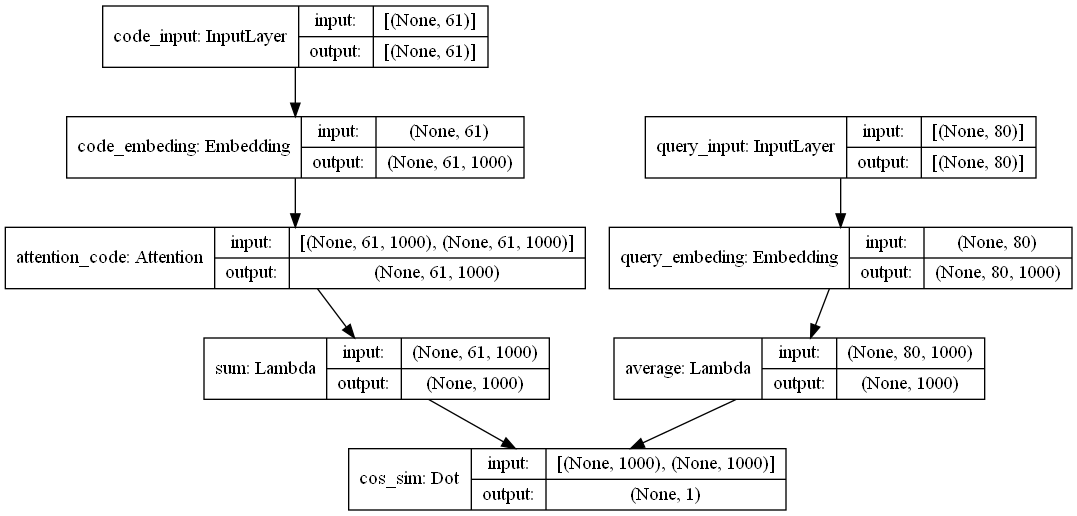

In [9]:


embedding_size = 1000

code_input = tf.keras.Input(shape=(longer_code,), name="code_input")
code_embeding = tf.keras.layers.Embedding(number_code_tokens, embedding_size, name="code_embeding")(code_input)

attention_code = tf.keras.layers.Attention(name="attention_code")([code_embeding, code_embeding])

query_input = tf.keras.Input(shape=(longer_desc,), name="query_input")
query_embeding = tf.keras.layers.Embedding(number_desc_tokens, embedding_size, name="query_embeding")(query_input)


code_output = tf.keras.layers.Lambda(lambda x: K.sum(x, axis=1), name="sum")( attention_code)
query_output = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1), name="average")( query_embeding)
#query_output = tf.keras.layers.GlobalAveragePooling1D(name="average")( query_embeding)

# This model generates code embedding
model_code = tf.keras.Model(inputs=[code_input], outputs=[code_output], name='model_code')
# This model generates description/query embedding
model_query = tf.keras.Model(inputs=[query_input], outputs=[query_output], name='model_query')

# Cosine similarity
# If normalize set to True, then the output of the dot product is the cosine proximity between the two samples.
cos_sim = tf.keras.layers.Dot(axes=1, normalize=True, name='cos_sim')([code_output, query_output]) 

#cos_sim = tf.keras.layers.Lambda(lambda x: cosine_similarity(x[0], x[1], axis=1),
#                        output_shape=lambda x: x[0], name='similarity')([query_output, code_output])


# This model calculates cosine similarity between code and query pairs
cos_model = tf.keras.Model(inputs=[code_input, query_input], outputs=[cos_sim],name='sim_model')  

cos_model.compile( loss='binary_crossentropy', optimizer='adam' ) # metrics=["accuracy"]

# Negative sampling
good_code_input = tf.keras.Input(shape=(longer_code,), name="good_code_input")
good_desc_input = tf.keras.Input(shape=(longer_desc,), name="good_desc_input")
bad_desc_input = tf.keras.Input(shape=(longer_desc,), name="bad_desc_input")

good_desc_output = cos_model([good_code_input, good_desc_input])
bad_desc_output = cos_model([good_code_input, bad_desc_input])

margin = 0.05
#loss = tf.keras.layers.Lambda(lambda x: K.maximum(1e-6, margin - x[0] + x[1]), output_shape=lambda x: x[0], name='loss')([good_desc_output, bad_desc_output])

#training_loss = tf.keras.layers.Lambda(lambda x: K.relu(margin - x[0] + x[1]),
#              output_shape=lambda x: x[0], name='hinge_loss')([good_desc_output, bad_desc_output])

training_loss = tf.keras.layers.Lambda(lambda x: K.maximum(1e-6, margin - x[0] + x[1]), output_shape=lambda x: x[0], name='loss')([good_desc_output, bad_desc_output])


training_model =  tf.keras.Model(inputs=[good_code_input, good_desc_input, bad_desc_input], outputs=[training_loss],name='training_model')


training_model.compile(loss=lambda y_true, y_pred:  y_pred+y_true-y_true, optimizer='adam') 
# y_true-y_true avoids warning

tf.keras.utils.plot_model(cos_model, "cos_model.png", show_shapes=True, expand_nested=True)


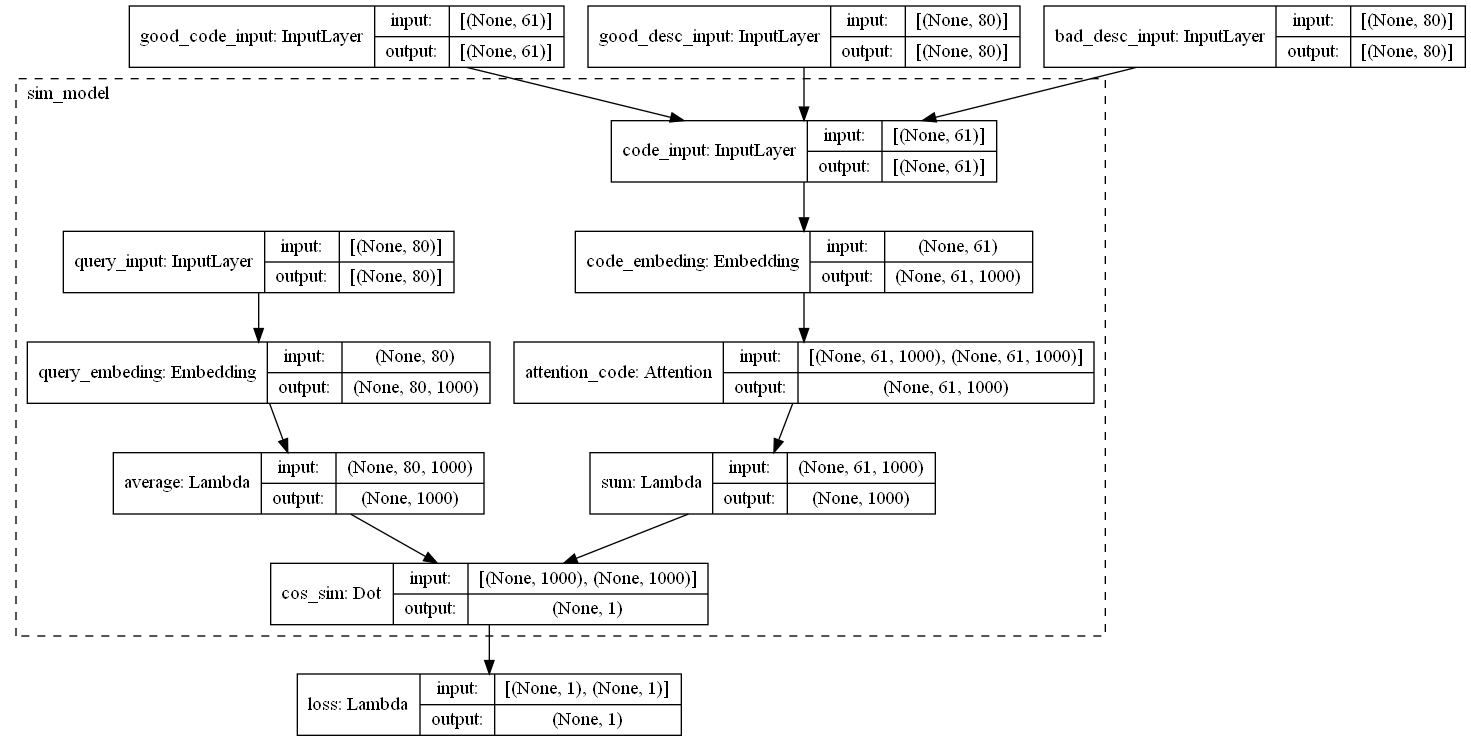

In [10]:
tf.keras.utils.plot_model(training_model, "training.png", show_shapes=True, expand_nested=True)

In [11]:

#code_vector
#desc_vector
negative_description_vector = desc_vector
random.shuffle(negative_description_vector)

results = np.zeros((len(desc_vector), 1))

print(len(code_vector), len(negative_description_vector), results.shape)

1000000 1000000 (1000000, 1)


In [ ]:

training_model.fit(x=[np.array(code_vector), np.array(desc_vector), np.array(negative_description_vector)], y=results, epochs=1, verbose=1, batch_size=32)

10469/31250 [=========>....................] - ETA: 1:08:13 - loss: 0.0500